# Solution to Question 2

## Python imports

Before executing code cells we load some required packages and initiate database connection.

In [1]:
import os # directory pathfinding
if 'notebooks' in os.getcwd(): # make sure jupyter server is in project root
    %cd ..

/Users/sampsa/Projects/rannala_project


In [2]:
import altair as alt # visualization library
import numpy as np  # linear algebra
import pandas as pd  # data processing
from IPython.display import display # show interactive sliders
from ipywidgets import interact # common interactivity features
import ipywidgets as widgets # package for interactivity

# import matplotlib.pyplot as plt
# import seaborn as sns
# color = sns.color_palette()

# alt.data_transformers.enable('json') # if number of records > 5000
# alt.renderers.enable('notebook') # Renderer for notebook (comment out if using jupyterlab)

import lib # project code package


In [3]:
# create a database connection
database = os.path.realpath('../rannala_project/db/rannala_project.db')
conn = lib.create_connection(database)

## Data Journey

Now we are ready to start exploring the dataset.

### First 5 rows of cleaned dataset

In [4]:
# read in dataset
df = pd.read_sql_query(
    '''SELECT f.*,
    cm.country
    FROM q2_clean f 
    INNER JOIN country_mapping cm on 
    f.alpha_2 = cm.alpha_2;''', conn)
df.head()

,alpha_2,hours_bucket,installs,country_total_installs,share_within_country,Country
0,AD,9,1,5,20.00,Andorra
1,AD,0,4,5,80.00,Andorra
2,AE,1,18,459,3.92,United Arab Emirates
3,AE,2,10,459,2.18,United Arab Emirates
4,AE,3,4,459,0.87,United Arab Emirates


### Data types in dataframe

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456 entries, 0 to 2455
Data columns (total 6 columns):
alpha_2                   2456 non-null object
hours_bucket              2456 non-null int64
installs                  2456 non-null int64
country_total_installs    2456 non-null int64
share_within_country      2456 non-null float64
Country                   2456 non-null object
dtypes: float64(1), int64(3), object(2)
memory usage: 115.2+ KB


### Field descriptions

- **country**: Country ISO2 code in lowercase.
- **hours_bucket**: Time difference in minutes between click and install, bucketed into hours. 0 means game was installs within - for 60 minutes, 1 means between 60-119 minutes, 2 means 120-179 minutes, and so on.
- **installs**: Number of installs in given country and time-to-install bucket.
- **country_total_installs**: Total number of installs in the given country, regardless of time to install.
- **share_within_country**: Share of installs within the given time-to-install bucket among all install in the given country

### Some basic statistical figures

In [6]:
df.describe()

,hours_bucket,installs,country_total_installs,share_within_country
count,2456.000000,2456.000000,2456.000000,2456.000000
mean,14.734935,65.723941,2609.676303,8.286889
std,12.962902,992.050942,8397.076320,22.357027
min,0.000000,1.000000,1.000000,0.010000
25%,4.000000,1.000000,167.000000,0.170000
50%,11.000000,2.000000,528.000000,0.520000
75%,24.000000,7.000000,1597.000000,2.220000
max,47.000000,45772.000000,59416.000000,100.000000


### First impression from data

By far most of the installs happen in the first (0) hour. One country is a much bigger player than any of the others (spoiler: the red color signifies United States).

It will be useful to sometimes view the dataset without US, to see better the variance within other countries' data.

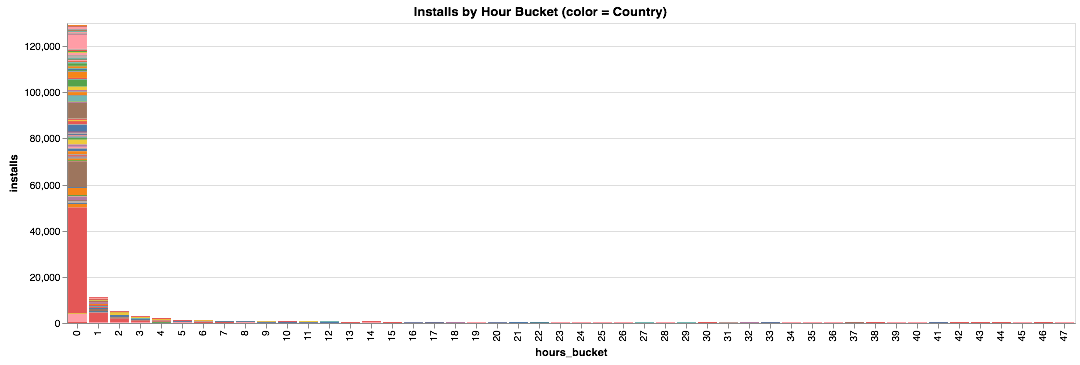

In [7]:
# Altair chart
alt.Chart(df).mark_bar().encode(
    x='hours_bucket:O',
    y='installs:Q',
    color=alt.Color('Country:N', legend=None)
).properties(
    title='Installs by Hour Bucket (color = Country)',
)

### Initial filters to slice the dataset 
(after setting these filters **rerun all code cells** in notebook to reload the reporting dataframe)

- Minimum hours_bucket (default = 0)
- Minimum country_total_installs (default = 1000)
- Countries to exclude (default = None)
    - Hold SHIFT and click to select multiple countries for exclusion

In [8]:
# Slider widget instance
x = 0
slider = widgets.IntSlider(description='bucket (min)',min=0,max=47,step=1)
slider.value = x
def on_change(v):
    x = v['new'] 
slider.observe(on_change, names='value')
display(slider)

IntSlider(value=0, description='bucket (min)', max=47)

In [9]:
# Slider widget instance
x = 1000
slider2 = widgets.IntSlider(description='country_total_installs (min)',min=0,max=50000,step=1000)
slider2.value = x
def on_change(v):
    x = v['new'] 
slider2.observe(on_change, names='value')
display(slider2)

IntSlider(value=1000, description='country_total_installs (min)', max=50000, step=1000)

In [10]:
# Slider widget instance
slider3 = widgets.SelectMultiple(
    options=sorted(df['Country'].unique()),
    value=[],
    #rows=10,
    description='Country',
    disabled=False
)
def on_change(v):
    value = v['new'] 
slider3.observe(on_change, names='value')
display(slider3)

SelectMultiple(description='Country', options=('Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra…

In [11]:
# Apply initial dataset filters to new dataframe df1
cond1 = df['hours_bucket']>= slider.value
cond2 = df['country_total_installs']>= slider2.value

df_temp = df[cond1 & cond2]

df1 = df_temp[~df_temp['Country'].isin(list(slider3.value))]

### Installs by Hour Bucket & Country

Here the dataset has already been filtered by the three preset filters defined above.

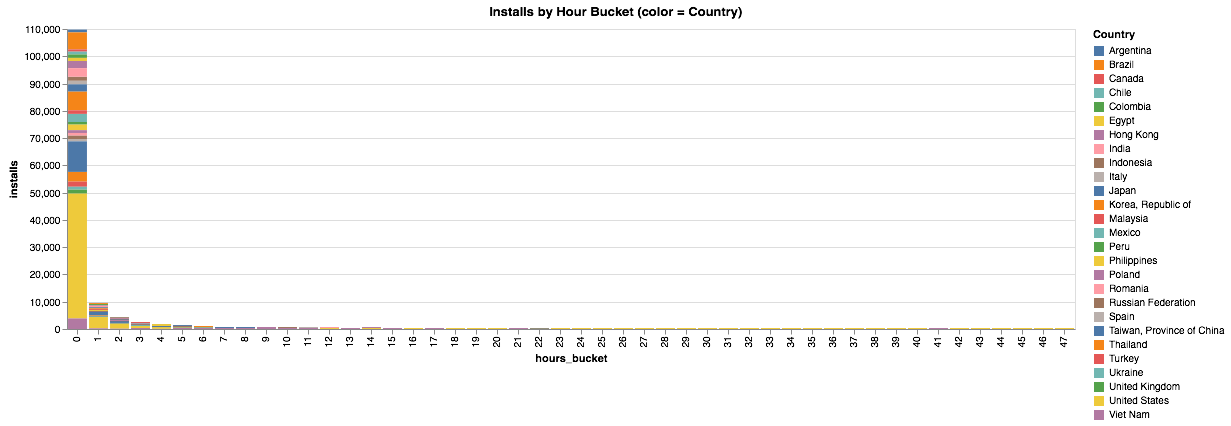

In [12]:
# Altair Chart
alt.Chart(df1).mark_bar().encode(
    x='hours_bucket:O',
    y='installs:Q',
    color=alt.Color('Country:N')
).properties(
    title='Installs by Hour Bucket (color = Country)',
)

### Further filtering in interactive mode

In the following chart, a live filter with Hour Bucket slider can be interacted with - the visualization responds immediately. No need to rerun code cells. The three original dataset filters still apply so we can't see data which has been filtered away at that stage.

In [13]:
# function that returns the interactive chart dataset
def filter_dataframe_bucket(bucket):
    df_bucket = df1[df1['hours_bucket'] >= bucket]
    #return df_bucket.describe()
    return alt.Chart(df_bucket).mark_bar().encode(
    x='hours_bucket:O',
    y='installs:Q',
    color=alt.Color('Country:N')
).properties(
    title='Installs by Hour Bucket (color = Country)',
)


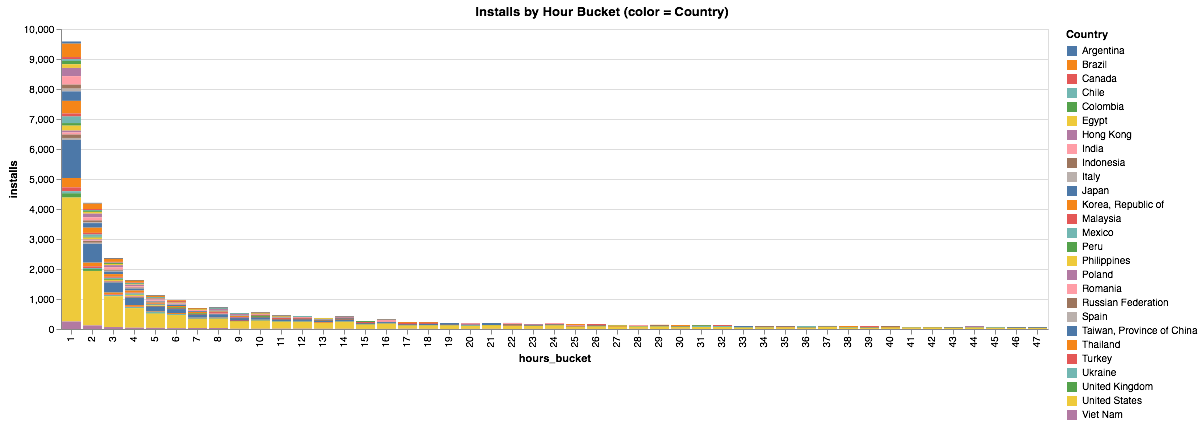

In [14]:
# Altair Chart
interact(filter_dataframe_bucket, bucket = widgets.IntSlider(description='bucket (min)',min=0,max=47,step=1,value=1), );

Next chart repeats the same approach, this time with an interactive country selector dropdown.

In [15]:
# function that returns the interactive chart dataset
def make_altair_chart(country):
    chart = alt.Chart(df1[df1['Country'] == country]).mark_bar().encode(
        alt.Y('Country:N', sort=alt.EncodingSortField(field="installs:Q", op="sum", order='descending')),
        alt.X('hours_bucket:O'),
        alt.Color('share_within_country:Q', scale=alt.Scale(scheme='greenblue'))
        )
    return chart

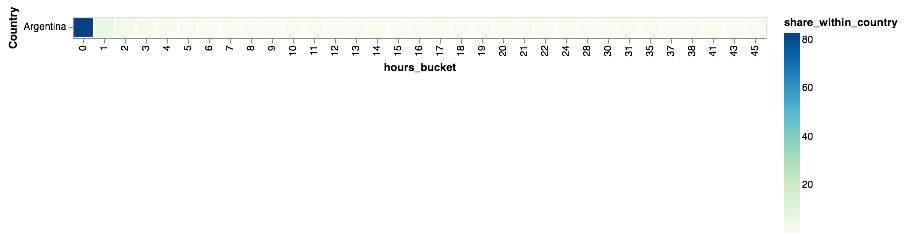

In [16]:
# Altair Chart
interact(make_altair_chart, country = sorted(df1['Country'].unique()), );

### Overview of share_within_country percentage per Hour Bucket

For each country it is clear that the majority of installs conclude in the first ("zero") hour after an ad is clicked.

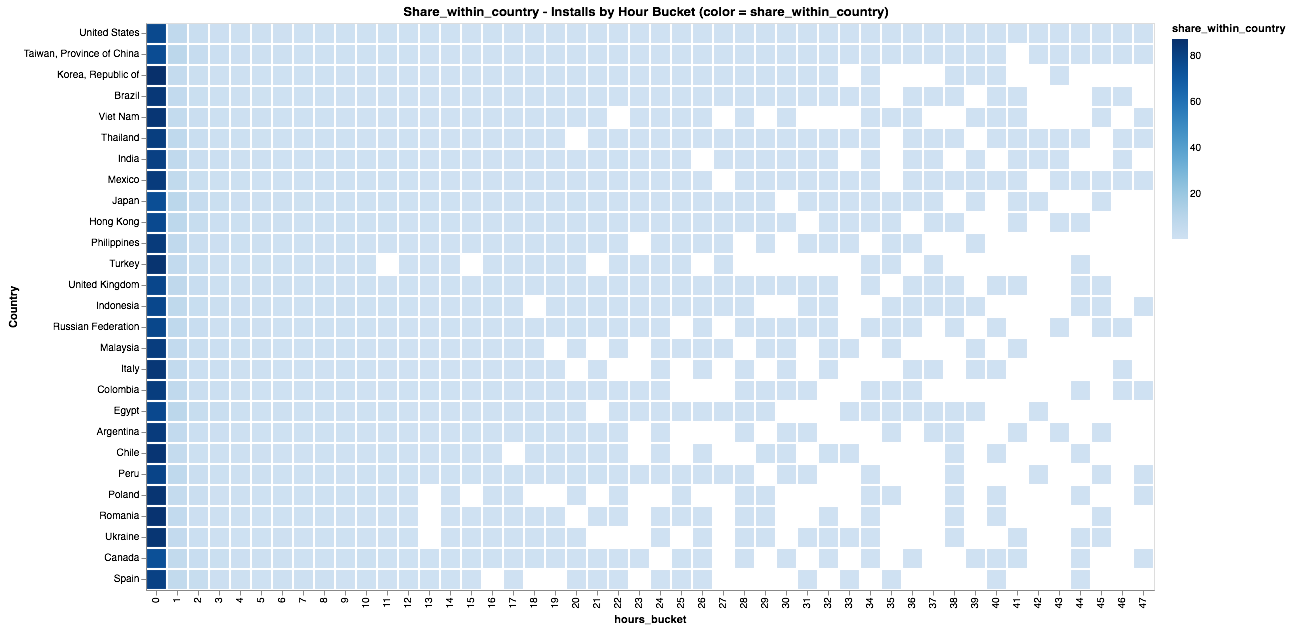

In [17]:
# Altair Chart
alt.Chart(df1).mark_bar().encode(
        alt.Y('Country:N', sort=alt.EncodingSortField(field="installs", op="sum", order='descending')),
        alt.X('hours_bucket:O'),
    alt.Color('share_within_country:Q') 
        ).properties(
    title='Share_within_country - Installs by Hour Bucket (color = share_within_country)',
)


### Conclusion

- Binned Hours Bucket vs Installs

Lets conclude by returning to the initial dataset without any filtering (only backend cleaning applied). With a simple binned chart we can conclude that the first couple hours (especially the very first hour) after click are critical. After that it becomes very unlikely that an ad-clicker would ever start the game in their mobile.

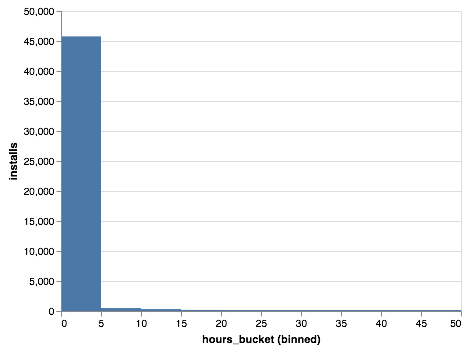

In [18]:
# Altair Chart
alt.Chart(df).mark_rect().encode(
    alt.X('hours_bucket:Q', bin=alt.Bin(maxbins=10)),
    alt.Y('installs:Q')
)

In [ ]:
sns.pairplot(df, x_vars=['TV','Radio','Newspaper'], y_vars='Sales', size=7, aspect=0.7, kind='reg')